# Relationship of the Tables in Schema eda.


The name of the table 'king_county_house_details' is misleading because it suggests that it is merely an attribute table associated with a main table.

In this case, the table ‘king_county_house_details’ is actually the main entity table. It also contains attributes related to the entity, such as geographical information, topological data about the properties, price details, among other things.

This is a 1:n relationship. Properties may have been sold multiple times. Therefore, the table ‘eda.king_county_house_sales’ represents the ‘n’ side of the relationship.

All potential entries in the ‘eda.king_county_house_sales’ table that do not have a corresponding entry in the ‘king_county_house_details’ table cannot be used, because no attributes are known for them apart from the sale date and price.

The database does not restrict orphaned entries in the ‘king_county_house_sales’ table. The necessary FOREIGN KEY constraints are missing.

Therefore, the following JOIN operation makes sense:
```
SELECT
	*
FROM
	eda.king_county_house_details d
JOIN eda.king_county_house_sales s ON
	s.house_id = d.id
```


There are 176 properties that have been sold more than once.
```
SELECT house_id, COUNT(*)
FROM king_county_house_sales s
GROUP BY house_id
HAVING COUNT(*) > 1;
```

# Extracting the joined tables and writing to folder data

In [1]:
import pandas as pd
import psycopg2
import os
from dotenv import load_dotenv
import numpy as np

import pandas as pd
from geopy.distance import geodesic
import math
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [2]:


load_dotenv()

DATABASE = os.getenv('DATABASE')
USER_DB = os.getenv('USER_DB')
PASSWORD = os.getenv('PASSWORD')
HOST = os.getenv('HOST')
PORT = os.getenv('PORT')

conn = psycopg2.connect(
    database=DATABASE,
    user=USER_DB,
    password=PASSWORD,
    host=HOST,
    port=PORT
)


query_string = "SELECT * FROM  eda.king_county_house_details d JOIN eda.king_county_house_sales s  ON s.house_id = d.id"
df_psycopg = pd.read_sql(query_string, conn)



/var/folders/lk/gq8wby6x3fv6n16s31xl4dg00000gn/T/ipykernel_37799/3731390376.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_psycopg = pd.read_sql(query_string, conn)


In [3]:
df_psycopg

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date,price,house_id,id
0,7129300520,3.0,1.00,1180.0,5650.0,1.0,NaN,0.0,3,7,...,0.0,98178,47.5112,-122.257,1340.0,5650.0,2014-10-13,221900.0,7129300520,1
1,6414100192,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,3,7,...,19910.0,98125,47.7210,-122.319,1690.0,7639.0,2014-12-09,538000.0,6414100192,2
2,5631500400,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,3,6,...,NaN,98028,47.7379,-122.233,2720.0,8062.0,2015-02-25,180000.0,5631500400,3
3,2487200875,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,5,7,...,0.0,98136,47.5208,-122.393,1360.0,5000.0,2014-12-09,604000.0,2487200875,4
4,1954400510,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,3,8,...,0.0,98074,47.6168,-122.045,1800.0,7503.0,2015-02-18,510000.0,1954400510,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,3.0,2.50,1530.0,1131.0,3.0,0.0,0.0,3,8,...,0.0,98103,47.6993,-122.346,1530.0,1509.0,2014-05-21,360000.0,263000018,21593
21593,6600060120,4.0,2.50,2310.0,5813.0,2.0,0.0,0.0,3,8,...,0.0,98146,47.5107,-122.362,1830.0,7200.0,2015-02-23,400000.0,6600060120,21594
21594,1523300141,2.0,0.75,1020.0,1350.0,2.0,0.0,0.0,3,7,...,0.0,98144,47.5944,-122.299,1020.0,2007.0,2014-06-23,402101.0,1523300141,21595
21595,291310100,3.0,2.50,1600.0,2388.0,2.0,NaN,0.0,3,8,...,0.0,98027,47.5345,-122.069,1410.0,1287.0,2015-01-16,400000.0,291310100,21596


In [4]:
# Number of unique zipcodes
print('number unique zipcodes: ', df_psycopg['zipcode'].nunique())

# length of the zipcodes
zip_length_counts = df_psycopg['zipcode'].astype(str).str.len().value_counts()
print(zip_length_counts)

startswith_98 = df_psycopg['zipcode'].astype(str).str.startswith('98')
startswith_98_counts = startswith_98.value_counts()
print('number zips starts with 98:', startswith_98_counts)

print(df_psycopg.shape)


number unique zipcodes:  70
zipcode
5    21597
Name: count, dtype: int64
number zips starts with 98: zipcode
True    21597
Name: count, dtype: int64
(21597, 23)


# SQRT OF LIVINIG PLACE

In [5]:
grouped_sqft = df_psycopg.groupby(['sqft_living', 'sqft_lot'])['price'].mean().reset_index()
print(grouped_sqft)

       sqft_living  sqft_lot      price
0            370.0    1801.0   276000.0
1            380.0   15000.0   245000.0
2            390.0    2000.0   245000.0
3            410.0    8636.0   325000.0
4            420.0    3298.0   229050.0
...            ...       ...        ...
20479       9640.0   13068.0  4670000.0
20480       9890.0   31374.0  6890000.0
20481      10040.0   37325.0  7060000.0
20482      12050.0   27600.0  7700000.0
20483      13540.0  307752.0  2280000.0

[20484 rows x 3 columns]


In [6]:
grouped_zip = df_psycopg.groupby(['zipcode'])['price'].mean().reset_index()
print(grouped_zip)

    zipcode         price
0     98001  2.811949e+05
1     98002  2.342840e+05
2     98003  2.941113e+05
3     98004  1.356524e+06
4     98005  8.102897e+05
..      ...           ...
65    98177  6.764194e+05
66    98178  3.106128e+05
67    98188  2.890783e+05
68    98198  3.028967e+05
69    98199  7.921879e+05

[70 rows x 2 columns]


# GEOGRAPHICAL INSIGHT

In [7]:
center_coords_seattle = (47.620564, -122.350616)

df_psycopg['distance_center_km'] = df_psycopg.apply(
    lambda row: geodesic(center_coords_seattle, (row['lat'], row['long'])).km,
    axis=1
)

In [8]:
grouped_distance = df_psycopg.groupby(['distance_center_km'])['price'].mean().reset_index()
print(grouped_distance)

max_dist = df_psycopg['distance_center_km'].max()
bins = np.arange(0, max_dist + 2, 2)
df_psycopg['distance_bin'] = pd.cut(df_psycopg['distance_center_km'], bins=bins)
grouped_distance = df_psycopg.groupby('distance_bin')['price'].mean().reset_index()

print(grouped_distance)

       distance_center_km     price
0                0.698171  453500.0
1                0.716120  700000.0
2                0.737670  707500.0
3                0.830809  478000.0
4                0.859704  550000.0
...                   ...       ...
20813           78.020889  375000.0
20814           78.158590  241000.0
20815           78.346439  155000.0
20816           78.430376  150000.0
20817           78.455014  167000.0

[20818 rows x 2 columns]
    distance_bin         price
0     (0.0, 2.0]  1.032562e+06
1     (2.0, 4.0]  7.441259e+05
2     (4.0, 6.0]  7.257865e+05
3     (6.0, 8.0]  6.075758e+05
4    (8.0, 10.0]  5.933711e+05
5   (10.0, 12.0]  6.524796e+05
6   (12.0, 14.0]  6.668855e+05
7   (14.0, 16.0]  5.080299e+05
8   (16.0, 18.0]  4.837937e+05
9   (18.0, 20.0]  5.732706e+05
10  (20.0, 22.0]  5.811184e+05
11  (22.0, 24.0]  5.236699e+05
12  (24.0, 26.0]  5.275655e+05
13  (26.0, 28.0]  4.970550e+05
14  (28.0, 30.0]  4.907691e+05
15  (30.0, 32.0]  3.926346e+05
16  (32.0, 34.0

/var/folders/lk/gq8wby6x3fv6n16s31xl4dg00000gn/T/ipykernel_37799/3041095626.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_distance = df_psycopg.groupby('distance_bin')['price'].mean().reset_index()


In [9]:
grouped_buil = df_psycopg.groupby(['yr_built'])['price'].mean().reset_index()
print(grouped_buil)

     yr_built          price
0        1900  581536.632184
1        1901  557108.344828
2        1902  673192.592593
3        1903  480958.195652
4        1904  583867.755556
..        ...            ...
111      2011  544648.384615
112      2012  527436.982353
113      2013  678599.582090
114      2014  683792.685152
115      2015  759970.947368

[116 rows x 2 columns]


# clustering grade

In [10]:
grouped_grade = df_psycopg.groupby(['grade'])['zipcode'].count().reset_index()
print(grouped_grade)

    grade  zipcode
0       3        1
1       4       27
2       5      242
3       6     2038
4       7     8974
5       8     6065
6       9     2615
7      10     1134
8      11      399
9      12       89
10     13       13


In [11]:
grouped_grade2 = df_psycopg.groupby(['zipcode','grade']).count().reset_index()
print(grouped_grade2)

     zipcode  grade   id  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0      98001      5    8         8          8            8         8       8   
1      98001      6   30        30         30           30        30      30   
2      98001      7  211       211        211          211       211     211   
3      98001      8   76        76         76           76        76      76   
4      98001      9   31        31         31           31        31      31   
..       ...    ...  ...       ...        ...          ...       ...     ...   
487    98199      8   99        99         99           99        99      99   
488    98199      9   50        50         50           50        50      50   
489    98199     10   33        33         33           33        33      33   
490    98199     11   10        10         10           10        10      10   
491    98199     13    1         1          1            1         1       1   

     waterfront  view  ...  lat  long  

In [12]:
grouped_grade2 = df_psycopg.groupby(['grade','zipcode']).count().reset_index()
print(grouped_grade2)

     grade  zipcode  id  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0        3    98022   1         1          1            1         1       1   
1        4    98010   1         1          1            1         1       1   
2        4    98014   3         3          3            3         3       3   
3        4    98023   1         1          1            1         1       1   
4        4    98024   1         1          1            1         1       1   
..     ...      ...  ..       ...        ...          ...       ...     ...   
487     13    98039   2         2          2            2         2       2   
488     13    98059   1         1          1            1         1       1   
489     13    98102   2         2          2            2         2       2   
490     13    98177   3         3          3            3         3       3   
491     13    98199   1         1          1            1         1       1   

     waterfront  view  ...  lat  long  sqft_living1

/var/folders/lk/gq8wby6x3fv6n16s31xl4dg00000gn/T/ipykernel_37799/1992212530.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


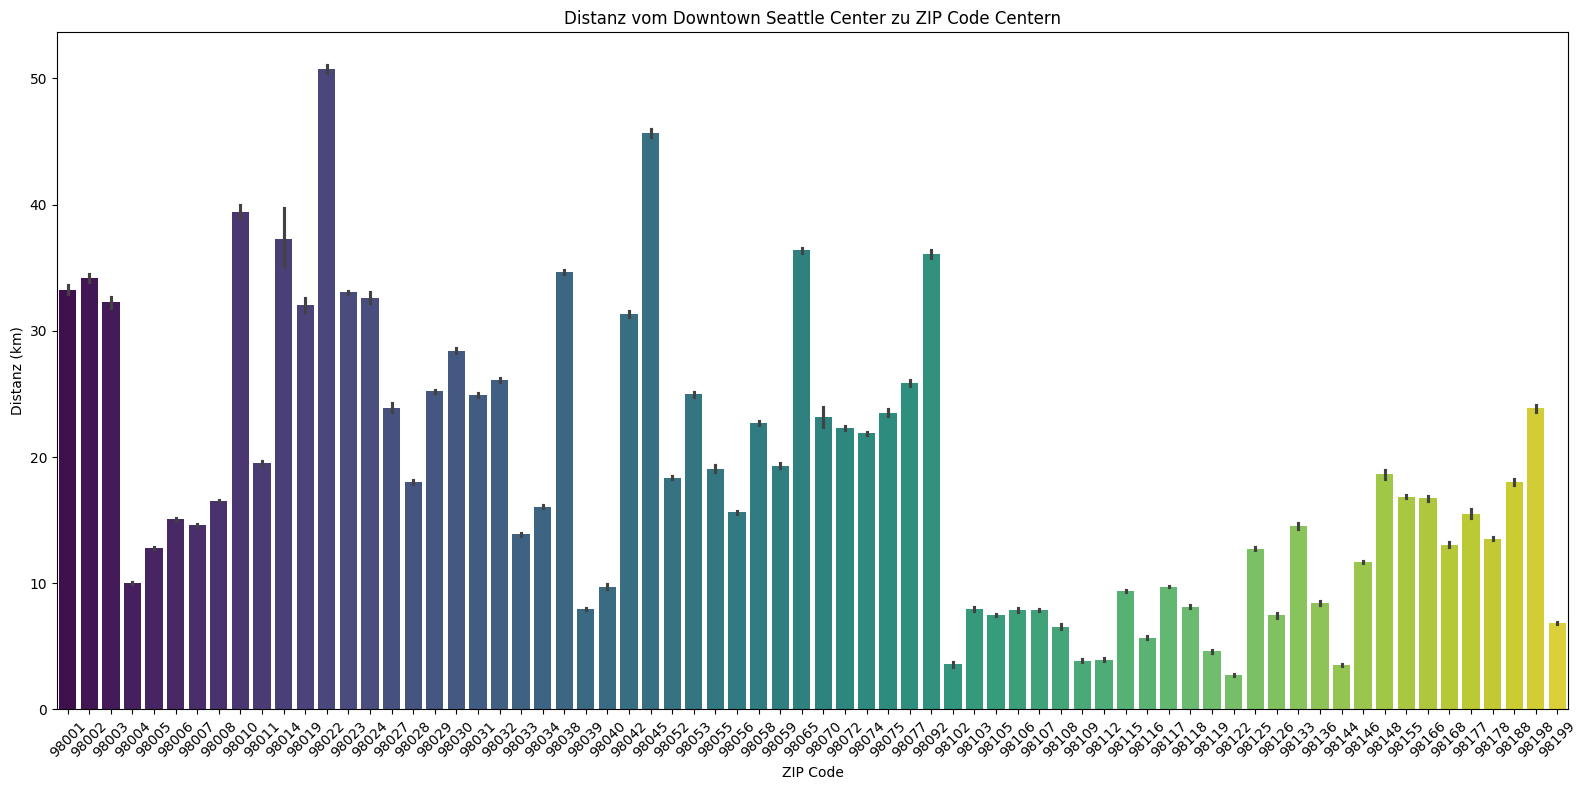

In [13]:
downtown_lat = 47.6050242
downtown_lon = -122.3343709 

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # km
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    d_phi = math.radians(lat2 - lat1)
    d_lambda = math.radians(lon2 - lon1)

    a = math.sin(d_phi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(d_lambda/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c


df_psycopg['distanz_to_downtown'] = df_psycopg.apply(
    lambda row: haversine(downtown_lat, downtown_lon, row['lat'], row['long']),
    axis=1
)
df_sorted = df_psycopg.sort_values('distanz_to_downtown', ascending=False)

zip_order = df_sorted['zipcode'].tolist()

plt.figure(figsize=(16, 8))
sns.barplot(
    data=df_psycopg,
    x='zipcode',
    y='distanz_to_downtown',
    palette='viridis'
)
plt.title('Distanz vom Downtown Seattle Center zu ZIP Code Centern')
plt.xlabel('ZIP Code')
plt.ylabel('Distanz (km)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

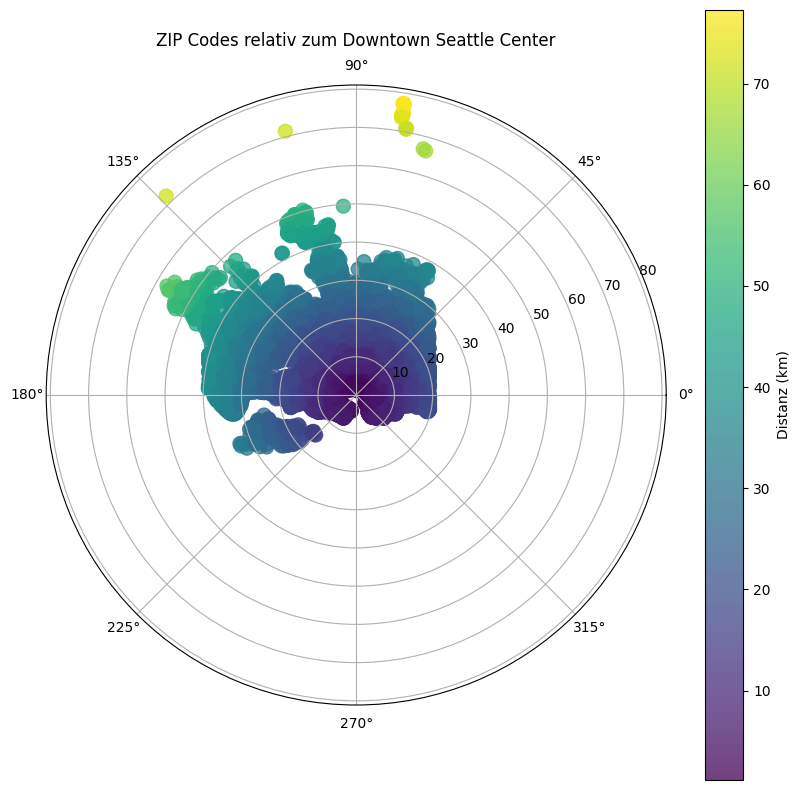

In [14]:
def calculate_bearing(lat1, lon1, lat2, lon2):
    """
    Berechnet den Azimut (Winkel) in Grad von Punkt 1 zu Punkt 2
    """
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    d_lambda = math.radians(lon2 - lon1)

    x = math.sin(d_lambda) * math.cos(phi2)
    y = math.cos(phi1)*math.sin(phi2) - math.sin(phi1)*math.cos(phi2)*math.cos(d_lambda)
    bearing = math.atan2(x, y)
    bearing = math.degrees(bearing)
    return (bearing + 360) % 360  

df_psycopg['bearing'] = df_psycopg.apply(
    lambda row: calculate_bearing(
        downtown_lat, downtown_lon, row['lat'], row['long']
    ), axis=1
)

angles = np.deg2rad(df_psycopg['bearing'])
radii = df_psycopg['distanz_to_downtown']

plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)

# Scatter Plot im Polar-System
c = ax.scatter(angles, radii, c=radii, cmap='viridis', s=100, alpha=0.75)

# Mittelpunkt ist Downtown = Radius 0
ax.set_title('ZIP Codes relativ zum Downtown Seattle Center', va='bottom')
plt.colorbar(c, label='Distanz (km)')

plt.show()

/var/folders/lk/gq8wby6x3fv6n16s31xl4dg00000gn/T/ipykernel_37799/4033620841.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


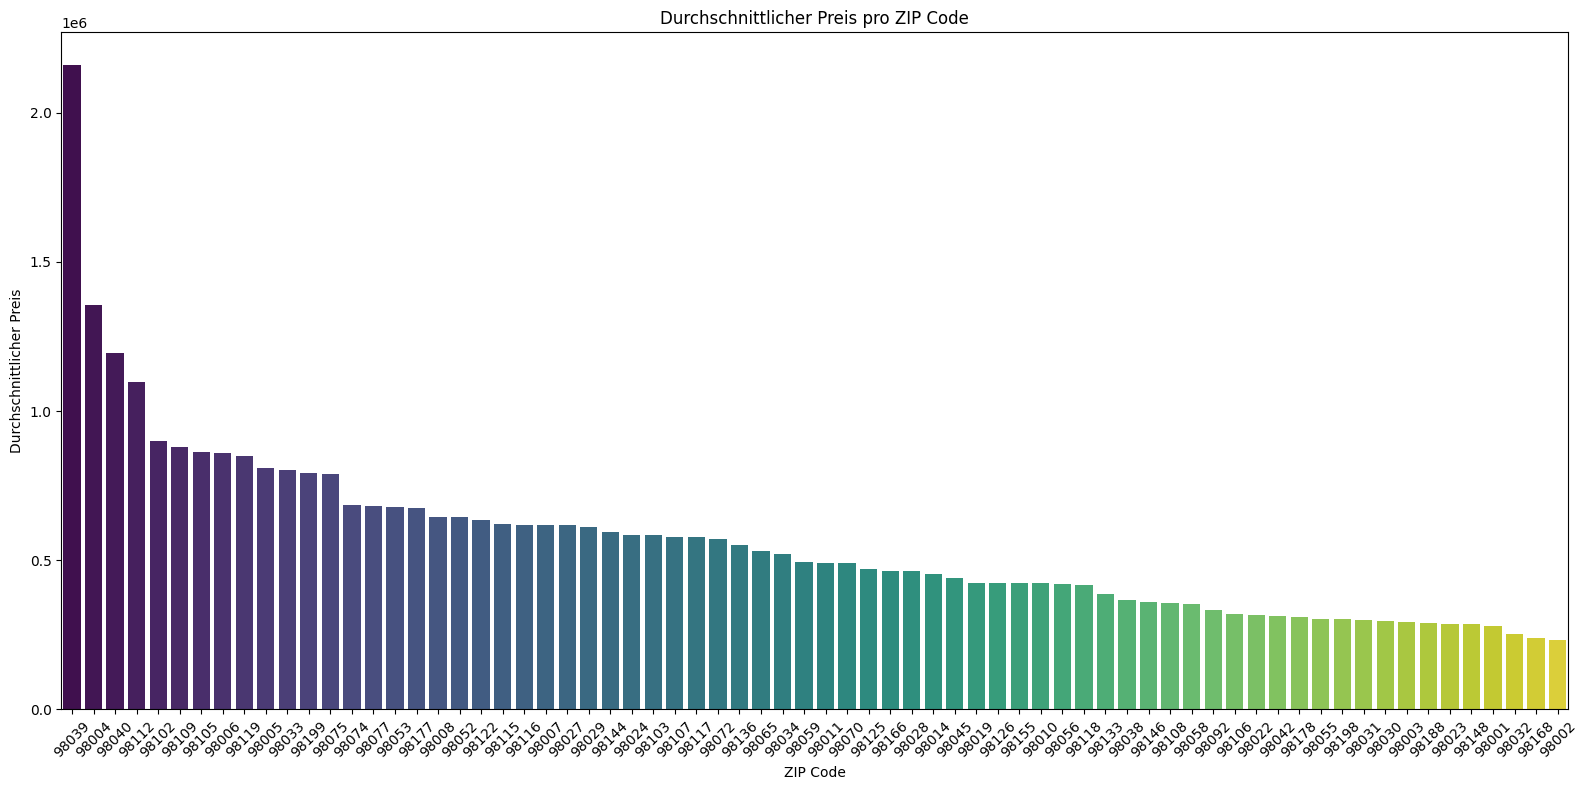

In [15]:
df_mean_price = (
    df_psycopg
    .groupby(['zipcode'])['price']
    .mean()
    .round(1)
    .reset_index()
)
df_mean_price = df_mean_price.sort_values('price', ascending=False)


plt.figure(figsize=(16, 8))

sns.barplot(
    data=df_mean_price,
    x='zipcode',
    y='price',
    order=df_mean_price['zipcode'],  # damit die ZIPs in sortierter Reihenfolge bleiben
    palette='viridis'
)

plt.title('Durchschnittlicher Preis pro ZIP Code')
plt.xlabel('ZIP Code')
plt.ylabel('Durchschnittlicher Preis')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
df_psycopg.to_csv('data/house_export_panda.csv',index=False)
conn.close()

In [17]:
df_psycopg

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_living15,sqft_lot15,date,price,house_id,id,distance_center_km,distance_bin,distanz_to_downtown,bearing
0,7129300520,3.0,1.00,1180.0,5650.0,1.0,NaN,0.0,3,7,...,1340.0,5650.0,2014-10-13,221900.0,7129300520,1,14.052538,"(14.0, 16.0]",11.939451,150.875521
1,6414100192,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,3,7,...,1690.0,7639.0,2014-12-09,538000.0,6414100192,2,11.416495,"(10.0, 12.0]",12.947193,5.095095
2,5631500400,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,3,6,...,2720.0,8062.0,2015-02-25,180000.0,5631500400,3,15.754015,"(14.0, 16.0]",16.610736,27.153102
3,2487200875,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,5,7,...,1360.0,5000.0,2014-12-09,604000.0,2487200875,4,11.541304,"(10.0, 12.0]",10.347013,205.182004
4,1954400510,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,3,8,...,1800.0,7503.0,2015-02-18,510000.0,1954400510,5,22.978055,"(22.0, 24.0]",21.731688,86.438786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,3.0,2.50,1530.0,1131.0,3.0,0.0,0.0,3,8,...,1530.0,1509.0,2014-05-21,360000.0,263000018,21593,8.761024,"(8.0, 10.0]",10.519118,355.254301
21593,6600060120,4.0,2.50,2310.0,5813.0,2.0,0.0,0.0,3,8,...,1830.0,7200.0,2015-02-23,400000.0,6600060120,21594,12.244886,"(12.0, 14.0]",10.691324,191.191884
21594,1523300141,2.0,0.75,1020.0,1350.0,2.0,0.0,0.0,3,7,...,1020.0,2007.0,2014-06-23,402101.0,1523300141,21595,4.850182,"(4.0, 6.0]",2.903306,113.997231
21595,291310100,3.0,2.50,1600.0,2388.0,2.0,NaN,0.0,3,8,...,1410.0,1287.0,2015-01-16,400000.0,291310100,21596,23.247295,"(22.0, 24.0]",21.397508,111.401209


/var/folders/lk/gq8wby6x3fv6n16s31xl4dg00000gn/T/ipykernel_37799/2904920374.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


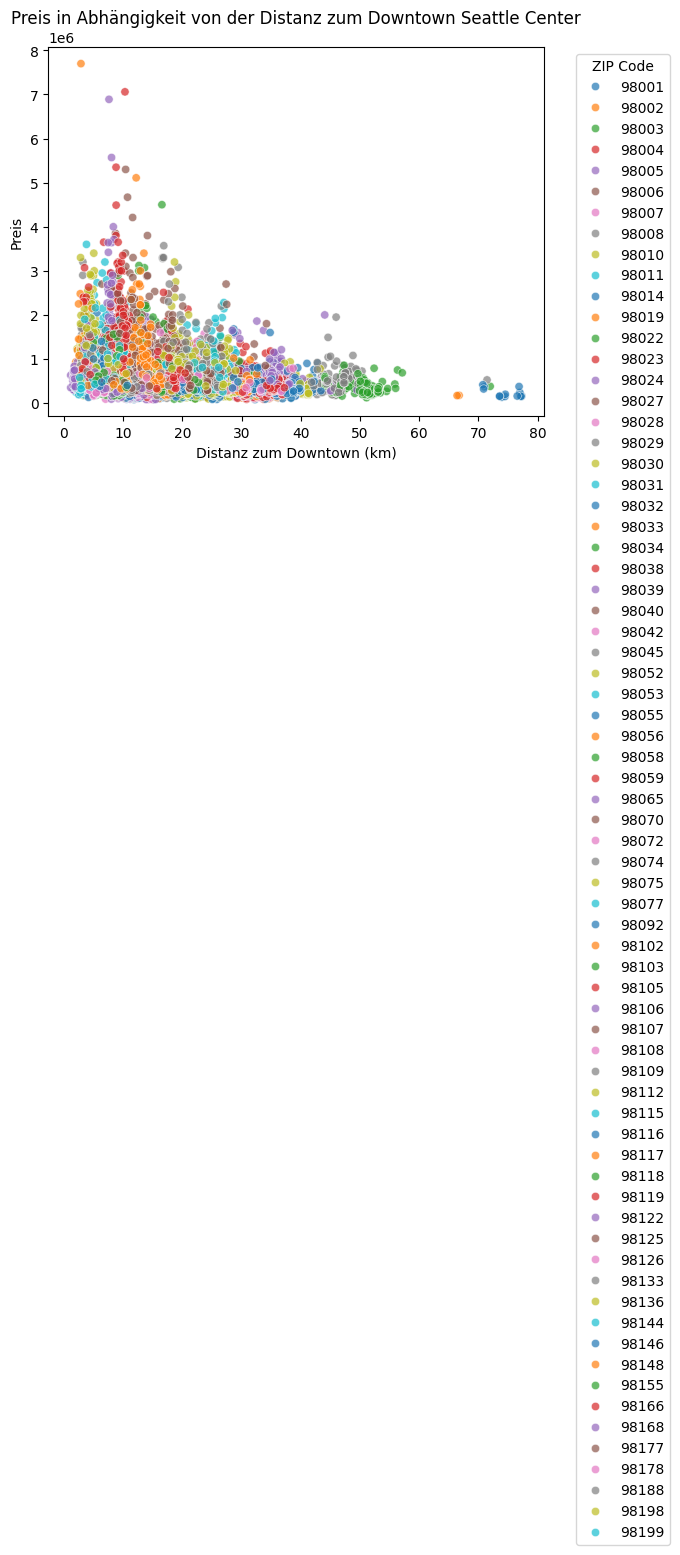

In [18]:
sns.scatterplot(
    data=df_psycopg,
    x='distanz_to_downtown',
    y='price',
    hue='zipcode',     # optional: ZIP Code als Farbe
    palette='tab10',
    alpha=0.7
)

plt.title('Preis in Abhängigkeit von der Distanz zum Downtown Seattle Center')
plt.xlabel('Distanz zum Downtown (km)')
plt.ylabel('Preis')
plt.legend(title='ZIP Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

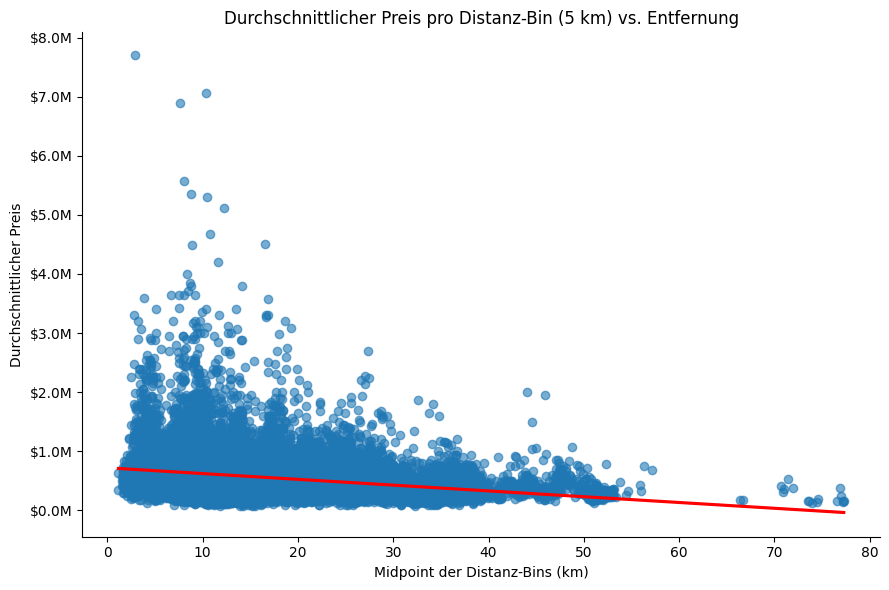

In [19]:
g = sns.lmplot(
    data=df_psycopg,
    x='distanz_to_downtown',
    y='price',
    height=6,
    aspect=1.5,
    scatter_kws={'alpha':0.6},
    line_kws={'color':'red'}
)
ax = g.axes[0,0]

# Formatter für Preis in Millionen $
formatter = FuncFormatter(lambda x, _: f'${x/1e6:.1f}M')
ax.yaxis.set_major_formatter(formatter)

# Achsentitel usw.
ax.set_title('Durchschnittlicher Preis pro Distanz-Bin (5 km) vs. Entfernung')
ax.set_xlabel('Midpoint der Distanz-Bins (km)')
ax.set_ylabel('Durchschnittlicher Preis')

plt.tight_layout()
plt.show()

/var/folders/lk/gq8wby6x3fv6n16s31xl4dg00000gn/T/ipykernel_37799/3165924655.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_zip.groupby('distance_bin')


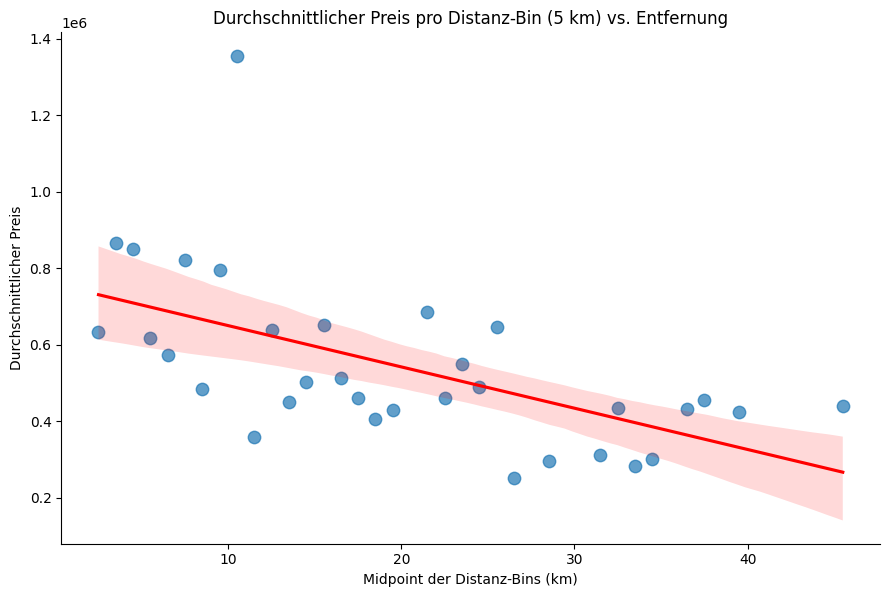

In [20]:
# ZIP-Durchschnitt pro ZIP
df_zip = (
    df_psycopg.groupby('zipcode')
    .agg({
        'price': 'mean',
        'distanz_to_downtown': 'mean'
    })
    .reset_index()
)

# Bins: alle 5 km
max_dist = df_zip['distanz_to_downtown'].max()
bin_edges = list(range(0, int(max_dist) + 1, 1))

# ZIPs in Bins stecken
df_zip['distance_bin'] = pd.cut(
    df_zip['distanz_to_downtown'],
    bins=bin_edges,
    include_lowest=True,
    right=False
)

# Pro Bin: Durchschnittspreis & Midpoint
df_bins = (
    df_zip.groupby('distance_bin')
    .agg({'price': 'mean'})
    .reset_index()
)

# Midpoint für jede Bin berechnen
df_bins['distance_mid'] = df_bins['distance_bin'].apply(lambda x: (x.left + x.right) / 2)

sns.lmplot(
    data=df_bins,
    x='distance_mid',
    y='price',
    height=6,
    aspect=1.5,
    scatter_kws={'s': 80, 'alpha': 0.7},
    line_kws={'color': 'red'}
)

plt.title('Durchschnittlicher Preis pro Distanz-Bin (5 km) vs. Entfernung')
plt.xlabel('Midpoint der Distanz-Bins (km)')
plt.ylabel('Durchschnittlicher Preis')
plt.show()


/var/folders/lk/gq8wby6x3fv6n16s31xl4dg00000gn/T/ipykernel_37799/3958457702.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_zip.groupby('distance_bin')


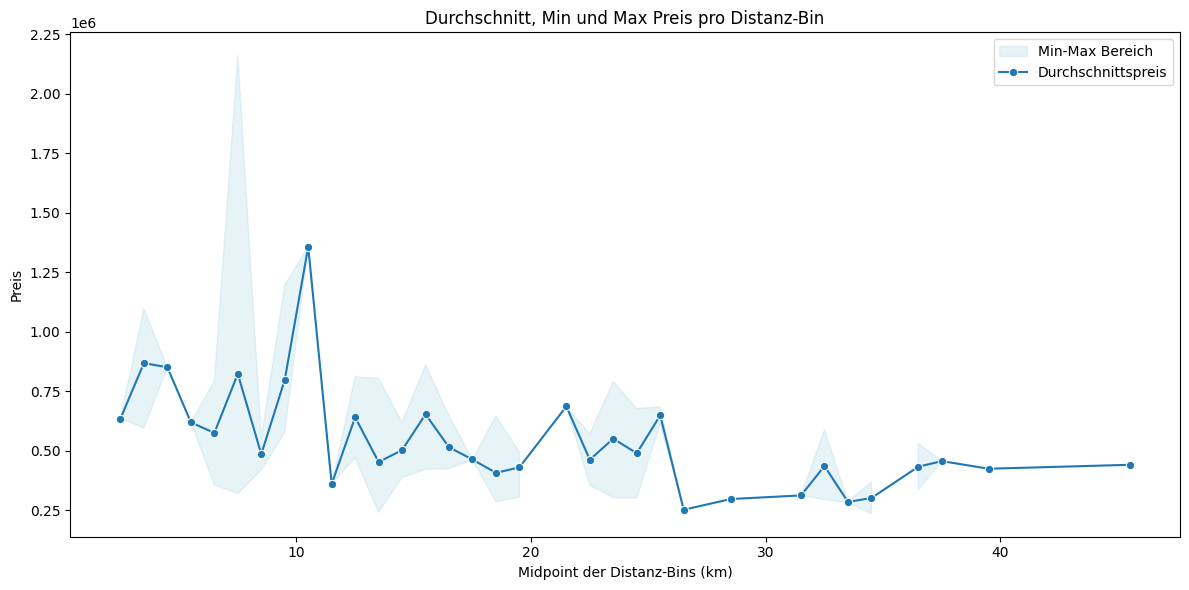

In [21]:
df_bins = (
    df_zip.groupby('distance_bin')
    .agg({
        'price': ['mean', 'min', 'max']
    })
    .reset_index()
)

# Spalten umbenennen
df_bins.columns = ['distance_bin', 'price_mean', 'price_min', 'price_max']

# Midpoint der Bins berechnen
df_bins['distance_mid'] = df_bins['distance_bin'].apply(lambda x: (x.left + x.right) / 2)

plt.figure(figsize=(12, 6))

# Min/Max-Bereich als Band zeichnen
plt.fill_between(
    df_bins['distance_mid'],
    df_bins['price_min'],
    df_bins['price_max'],
    color='lightblue',
    alpha=0.3,
    label='Min-Max Bereich'
)

# Mean als Linie mit Punkten
sns.lineplot(
    data=df_bins,
    x='distance_mid',
    y='price_mean',
    marker='o',
    label='Durchschnittspreis'
)

plt.title('Durchschnitt, Min und Max Preis pro Distanz-Bin')
plt.xlabel('Midpoint der Distanz-Bins (km)')
plt.ylabel('Preis')
plt.legend()
plt.tight_layout()
plt.show()

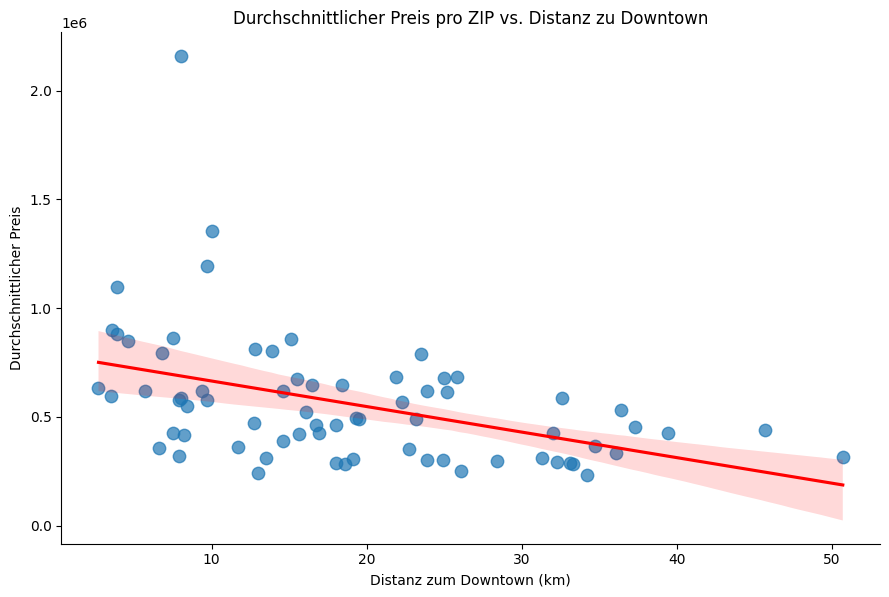

In [22]:
df_grouped3 = (
    df_psycopg.groupby('zipcode')
    .agg({
        'price': 'mean',
        'distanz_to_downtown': 'mean'
    })
    .round(1)
    .reset_index()
)
sns.lmplot(
    data=df_grouped3,
    x='distanz_to_downtown',
    y='price',
    height=6,
    aspect=1.5,
    scatter_kws={'s': 80, 'alpha': 0.7},
    line_kws={'color': 'red'}
)

plt.title('Durchschnittlicher Preis pro ZIP vs. Distanz zu Downtown')
plt.xlabel('Distanz zum Downtown (km)')
plt.ylabel('Durchschnittlicher Preis')
plt.show()

In [23]:
df_psycopg['price'].min()

np.float64(78000.0)